In [1]:
import os
os.environ["LOGLEVEL"] = "PROD"

import numpy as np
import pandas as pd
from neuro_dmt.models.bluebrain.circuit.model import BlueBrainCircuitModel
from neuro_dmt.models.bluebrain.circuit.mock.test.mock_circuit_light\
    import circuit_composition, circuit_connectivity
from neuro_dmt.models.bluebrain.circuit.mock.circuit import\
    MockCircuit

('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mtype', 'etype', 'synapse_class')
('region', 'layer', 'depth', 'height', 'mtype', 'etype', 'synapse_class')


In [2]:
mock_circuit =\
    MockCircuit.build(
        circuit_composition,
        circuit_connectivity)
circuit_model =\
    BlueBrainCircuitModel(
        mock_circuit,
        label="BlueBrainCircuitModelMock")
conn_prob = circuit_model.connection_probability

In [4]:
pre_synaptic_cells =\
    circuit_model.cells\
                 .sample(n=100)\
                 .rename(columns=conn_prob._at("pre_synaptic"))
post_synaptic_cells =\
    circuit_model.cells\
                 .sample(n=100)\
                 .rename(columns=conn_prob._at("post_synaptic"))
conn_prob(
    pre_synaptic_cell_group=pre_synaptic_cells,
    post_synaptic_cell_group=post_synaptic_cells)

number_pairs_total            10000.0
number_pairs_connected          168.0
number_cells_pre_synaptic       100.0
number_cells_post_synaptic      100.0
Name: 0, dtype: float64

In [6]:
from neuro_dmt import terminology
from neuro_dmt.models.bluebrain.circuit.model.pathway import connectome_summary

connectome_summary(
    conn_prob(
        pre_synaptic_cell_group=circuit_model.cells,
        post_synaptic_cell_group=circuit_model.get_cells(mtype="L23_MC").sample(n=20),
        sampling_methodology=terminology.sampling_methodology.exhaustive))

number_cells_pre_synaptic       10288.000000
number_cells_post_synaptic         20.000000
number_pairs_total             205760.000000
number_pairs_connected           4144.000000
probability_connection              0.020140
number_connections_afferent       207.200000
number_connections_efferent         0.402799
dtype: float64

In [5]:
conn_prob(
    pre_synaptic_cell_group=circuit_model.get_cells(**{"mtype": "L23_MC"}),
    post_synaptic_cell_group=circuit_model.get_cells(**{"mtype": "L23_MC"}),
    with_summary_statistics=True)

pairs_total               10000.0000
pairs_connected             187.0000
connection_probability        0.0187
Name: 0, dtype: float64

In [4]:
conn_prob_sd =\
    circuit_model.connection_probability_by_soma_distance
measurement_pairs =\
    conn_prob_sd.get_pairs(
        circuit_model.get_cells(**{"mtype": "L23_MC"}),
        circuit_model.get_cells(**{"mtype": "L23_MC"}))
pairs_agg =\
    pd.concat([
        pairs[
        ["pairs"]
        ].reset_index(
            drop=True
        ).assign(
            dummy_variable=0
        ).groupby(
            ["dummy_variable"]
        ).agg(
            ["sum", "size"]
        ).pairs.rename(
            columns={"size": "pairs_total", "sum": "pairs_connected"}
        ) for pairs in measurement_pairs]
    ).groupby(
        "dummy_variable"
    ).agg(
        "sum"
    )
pairs_agg.join(
    pairs_agg.apply(
        lambda df: df.pairs_connected / df.pairs_total,
        axis=1
    ).rename(
        "connection_probability"
    )
)

,pairs_connected,pairs_total,connection_probability
dummy_variable,,,
0,527.0,26896,0.019594


In [14]:
connection_strength.columns

{'sum': 'connection_strength'}

In [25]:
from neuro_dmt.models.bluebrain.circuit.model.cell_type import\
    CellType
from neuro_dmt.models.bluebrain.circuit.model.pathway.connection_probability import\
    ConnectionProbability,\
    ConnectionProbabilityBySomaDistance

class ConnectionStrength(ConnectionProbability):
    """
    Count the number of connections in a pathway
    """
    phenomenon = "connection_strength"
    aggregators_inner = ["sum"]
    aggregators_outer = ["size", "mean", "std"]
    measurement_label = "connection_strength"
    columns = {"sum": "connection_strength"}
    
    @property
    def definition(self):
        """..."""
        return {}
    
class AfferentConnectionStrengthBySomaDistance(
        ConnectionProbabilityBySomaDistance):
    """..."""
    phenomenon = "Afferent Connections"
    aggregators_inner = ["sum"]
    aggregators_outer = ["size", "mean", "std"]
    measurement_label = "afferent_connections"
    columns = {"sum": "afferent_connections"}

    @property
    def definition(self):
        return {}

measurement_pairs =\
    conn_prob_sd.get_pairs(
        circuit_model.get_cells(**{"mtype": "L23_MC"}),
        circuit_model.get_cells(**{"mtype": "L23_MC"}))
connection_strength =\
    ConnectionStrength(circuit_model=circuit_model)
aff_conn_sd =\
    AfferentConnectionStrengthBySomaDistance(
        circuit_model=circuit_model)
pairs_agg_acsd =\
    aff_conn_sd(
        pathway=CellType.pathway(
            {"mtype": "L23_MC"},
            {"mtype": "L23_MC"}))
pairs_agg_cs =\
    connection_strength(
        pathway=CellType.pathway(
            {"mtype": "L23_MC"},
            {"mtype": "L23_MC"}))

pairs_agg_d =\
    pd.concat([
        pairs[
            ["pairs", "soma_distance"]
        ].reset_index(
            drop=True
        ).assign(
            dummy_variable=0
        ).groupby(
            ["dummy_variable", "soma_distance"]
        ).agg(
            ["sum"]
        ).pairs.rename(
            columns={"sum": "connection_strength"}
        ) for pairs in measurement_pairs]
    ).groupby(
        ["dummy_variable", "soma_distance"]
    ).agg(
        ["size", "mean", "std"]
    ).assign(**{})
pairs_agg

connection_strength                    
                                             size      mean       std
dummy_variable soma_distance                                         
0              (0.0, 100.0)                   164  0.347561  0.549339
               (100.0, 200.0)                 164  1.079268  1.161682
               (200.0, 300.0)                 164  1.060976  0.988865
               (300.0, 400.0)                 158  0.727848  0.981671
               (400.0, 500.0)                  72  0.055556  0.230669

In [26]:
pairs_agg_acsd


,size,mean,std
soma_distance,,,
"(0.0, 100.0)",100,0.190000,0.419114
"(100.0, 200.0)",100,0.580000,0.806288
"(200.0, 300.0)",100,0.540000,0.783929
"(300.0, 400.0)",98,0.489796,0.827926
"(400.0, 500.0)",42,0.000000,0.000000


In [14]:
np.isnan(cp_pairs[0].pairs.values).sum()

0

In [7]:
pre_synaptic_cell_group = circuit_model.cells.sample(n=100)
post_synaptic_cell_group = circuit_model.cells.sample(n=100)
conn_prob(
    pre_synaptic_cell_group=pre_synaptic_cell_group,
    post_synaptic_cell_group=post_synaptic_cell_group,
    upper_bound_soma_distance=1000,
    with_summary_statistics=True)

pairs_total               8868.000000
pairs_connected            174.000000
connection_probability       0.019621
Name: 0, dtype: float64

In [8]:
conn_prob(
    pre_synaptic_cell_group=pre_synaptic_cell_group,
    post_synaptic_cell_group=post_synaptic_cell_group,
    upper_bound_soma_distance=100.,
    with_summary_statistics=True)

pairs_total               334.00000
pairs_connected             5.00000
connection_probability      0.01497
Name: 0, dtype: float64

In [9]:
conn_prob(
    pre_synaptic_cell_group=pre_synaptic_cell_group,
    post_synaptic_cell_group=post_synaptic_cell_group,
    with_summary_statistics=True)

pairs_total               10000.0000
pairs_connected             197.0000
connection_probability        0.0197
Name: 0, dtype: float64

In [4]:
from dmt.tk.parameters import Parameters
from neuro_dmt.models.bluebrain.circuit.adapter import\
    BlueBrainCircuitAdapter

parameters_pathways_with_soma_distance = Parameters(
    circuit_model.pathways(
        {"mtype",}
    ).assign(
        upper_bound_soma_distance=500.
    ))
adapter = BlueBrainCircuitAdapter()
parameters_for_sampling =\
    parameters_pathways_with_soma_distance.for_sampling(size=10)
adapter.get_connection_probability(
    circuit_model,
    **parameters_for_sampling[0])

('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')


dummy_variable
0    0.02102
Name: connection_probability, dtype: float64

In [5]:
parameters_pathways_with_soma_distance = Parameters(
    circuit_model.pathways(
        {"mtype",}
    ).assign(
        upper_bound_soma_distance=50.
    ))
adapter = BlueBrainCircuitAdapter()
parameters_for_sampling =\
    parameters_pathways_with_soma_distance.for_sampling(size=10)
adapter.get_connection_probability(
    circuit_model,
    **parameters_for_sampling[0])

dummy_variable
0    0.029801
Name: connection_probability, dtype: float64

In [6]:
from neuro_dmt.models.bluebrain.circuit.model.pathway import\
    ConnectionProbabilityBySomaDistance
conn_prob_sd = ConnectionProbabilityBySomaDistance(circuit_model=circuit_model)

In [ ]:
conn_prob_sd(
    pre_synaptic_cell_group=pre_synaptic_cells,
    post_synaptic_cell_group=post_synaptic_cells)

In [11]:
conn_prob(
    pre_synaptic_cell_group=pre_synaptic_cells,
    post_synaptic_cell_group=post_synaptic_cells,
    with_summary_statistics=True).loc[0]["connection_probability"]

0.0199

In [19]:
measurement_pairs = conn_prob_sd.get_pairs(
    pre_synaptic_cells=pre_synaptic_cells,
    post_synaptic_cells=post_synaptic_cells)
cpdf =\
    pd.concat([
        pairs[
            ["pairs", "soma_distance"]
        ].reset_index(
            drop=True
        ).assign(
            group=0
        ).groupby(
            ["group", "soma_distance"]
        ).agg(
            conn_prob.aggregators
        ).pairs.rename(
            columns=conn_prob.columns
        ) for pairs in measurement_pairs]
    ).groupby(
        ["group", "soma_distance"]
    ).agg(
        "sum"
    ).assign(**{
        conn_prob.phenomenon: conn_prob.definition}
    ).loc[0]

In [23]:
print(conn_prob_sd.measured_variables, conn_prob_sd.other_grouping_variables)
conn_prob_sd._full_summary(
    conn_prob_sd.get_pairs(
        pre_synaptic_cells=pre_synaptic_cells,
        post_synaptic_cells=post_synaptic_cells))

['pairs', 'soma_distance'] []


pairs_total               10000.0000
pairs_connected             173.0000
connection_probability        0.0173
Name: 0, dtype: float64

In [ ]:
pre_synaptic_group_columns = ["pre_synaptic_mtype"]
post_synaptic_group_columns = ["post_synaptic_mtype"]
result = pairs_df[
    ["pairs", "soma_distance"] + pre_synaptic_group_columns + post_synaptic_group_columns
].groupby(
    pre_synaptic_group_columns
    + post_synaptic_group_columns
    + ["soma_distance"]
).agg(["size", "sum"])
result.head()

In [ ]:
result = pairs_df[
    ["pairs"]
].assign(
    group=0
).groupby(
    ["group"]
).agg(
    ["sum", "size"]
).pairs.rename(
    columns=conn_prob.columns
)
conn_prob.definition(result.loc[0])

In [ ]:
result = pairs_df[
    ["soma_distance"] + ["pairs"]
].assign(
    group=0
).groupby(
    ["group", "soma_distance"]
).agg(
    ["sum", "size"]
).pairs.rename(
    columns=conn_prob.columns
)
conn_prob.definition(result.loc[0])

In [ ]:
result = pairs_df[
    ["soma_distance"] + ["pairs"]
].assign(group=0
).groupby(
    ["group", "soma_distance"]
).agg(
    ["sum", "size"]
).pairs.rename(
    columns=conn_prob.columns
).assign(
    **{conn_prob.phenomenon: conn_prob.definition}
).loc[0][
    conn_prob_sd.measurement_label
]
result

In [ ]:
result = pairs_df[
    ["pairs", "soma_distance"]
].groupby(
    ["soma_distance"]
).agg(
    ["sum", "size"]
).pairs.rename(
    columns=conn_prob_sd.columns
).assign(**{
    conn_prob_sd.phenomenon: conn_prob_sd.definition})
result[
    conn_prob_sd.phenomenon
].head()

In [ ]:
result = pairs_df[
    ["pairs"]
].agg(
    conn_prob.aggregators
).pairs.rename(
    columns=conn_prob.columns
)
result

In [ ]:
result = pairs_df[
    ["pairs", "soma_distance"]
].groupby(
    ["soma_distance"]
).agg(
    ["sum", "size"]
).pairs.rename(
    columns=conn_prob.columns
).assign(**{
    conn_prob_sd.phenomenon: conn_prob_sd.definition})

result[conn_prob_sd.measurement_label]


In [ ]:
from neuro_dmt.models.bluebrain.circuit.model.pathway import GroupByVariables

result_dataframe_groupby = conn_prob_sd(
    pre_synaptic_cell_group=circuit_model.cells.sample(n=100),
    post_synaptic_cell_group=circuit_model.cells.sample(n=100),
    groupby=GroupByVariables(frozenset({"mtype",}), frozenset({"mtype",})))

In [ ]:
from neuro_dmt.models.bluebrain.circuit.model.cell_type import CellType
result_series = conn_prob_sd(
    pathway=CellType.pathway(
        {"mtype": "L6_UPC"},
        {"mtype": "L6_TPC:A"}))

In [ ]:
result_series.apply(
    lambda x: x + np.random.uniform())

In [ ]:
from dmt.data.observation.measurement.collection import series_type, primitive_type
measured_values = series_type([
    ({"pre_synaptic_mtype": "L23_MC", "post_synaptic_mtype": "L23_MC"},
     result_series.apply(lambda x: x + 0.01 * np.random.uniform())),
    ({"pre_synaptic_mtype": "L23_MC", "post_synaptic_mtype": "L23_MC"},
     result_series.apply(lambda x: x + 0.01 * np.random.uniform())),
    ({"pre_synaptic_mtype": "L23_MC", "post_synaptic_mtype": "L23_MC"},
     result_series.apply(lambda x: x + 0.01 * np.random.uniform())),
    ({"pre_synaptic_mtype": "L23_MC", "post_synaptic_mtype": "L6_TPC:A"},
     result_series.apply(lambda x: x + 0.01 * np.random.uniform())),
    ({"pre_synaptic_mtype": "L23_MC", "post_synaptic_mtype": "L6_TPC:A"},
     result_series.apply(lambda x: x + 0.01 * np.random.uniform())),
    ({"pre_synaptic_mtype": "L23_MC", "post_synaptic_mtype": "L6_TPC:A"},
     result_series.apply(lambda x: x + 0.01 * np.random.uniform())),
    ({"pre_synaptic_mtype": "L6_UPC", "post_synaptic_mtype": "L6_TPC:A"},
     result_series.apply(lambda x: x + 0.01 * np.random.uniform())),
    ({"pre_synaptic_mtype": "L6_UPC", "post_synaptic_mtype": "L6_TPC:A"},
     result_series.apply(lambda x: x + 0.01 * np.random.uniform())),
    ({"pre_synaptic_mtype": "L6_UPC", "post_synaptic_mtype": "L6_TPC:A"},
     result_series.apply(lambda x: x + 0.01 * np.random.uniform()))]
).rename(columns={"value": "connection_probability"})

In [ ]:
from dmt.data.observation import measurement
measured_data = measurement.get_summary(measured_values).reset_index()

In [11]:
from neuro_dmt.models.bluebrain.circuit.test.test_connectome_analysis import *
phenomenon = Phenomenon(
    "Connection Probability",
    """
    Probability that two neurons in a pathway are connected.
    While mostly interested in `mtype->mtype` pathways, we can define
    a pathway as the group of connected neurons with pre-synaptic and
    post-synaptic neurons belonging to two parametrically defined groups.
    As an example consider neuron populations defined by not only `mtype`
    but also by soma-distance from a given location.
    """,
    group="Connectome")
number_pathways = 5
pathways =\
    mock_circuit_model.pathways(frozenset(("mtype",)))\
        .sample(n=number_pathways)

('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')


In [89]:
from collections import OrderedDict
from dmt.data.observation import measurement

adapter =\
    analysis_test.adapter
cell_types=pd.DataFrame([
    OrderedDict({"mtype": "L23_MC"}),
    OrderedDict({"mtype": "L6_TPC:A"}), 
    OrderedDict({"mtype": "L5_TPC:A"}),
    OrderedDict({"mtype": "L5_MC"}),
    OrderedDict({"mtype": "L6_ChC"})])
pathways =\
    adapter.get_pathways(
        mock_circuit_model,
        cell_group=cell_types)
analysis_test = BlueBrainCircuitAnalysisTest(
    analysis=BrainCircuitAnalysis(
    phenomenon=phenomenon,
    AdapterInterface=ConnectionProbabilityBySomaDistanceInterface,
    measurement_parameters=Parameters(pathways),
    measurement_collection=measurement.collection.series_type,
    plotter=HeatMap(
        xvar=("pre_synaptic", "mtype"),
        xlabel="pre-mtype",
        yvar=("post_synaptic", "mtype"),
        ylabel="post-mtype",
        vvar=("connection_probability", "mean"))))

connection_probability_measurement =\
    analysis_test.test_get_measurement(
        mock_circuit_model,
        sample_size=2)

analysis = analysis_test._circuit_analysis_test.analysis

In [90]:
cpm =\
    connection_probability_measurement["BlueBrainCircuitModelMockLight"]
cpm.head()

connection_probability
(pre_synaptic, mtype) (post_synaptic, mtype) soma_distance                        
L23_MC                L23_MC                 50.0                         0.020376
                                             150.0                        0.016684
                                             250.0                        0.017182
                                             350.0                        0.019244
                                             450.0                        0.022222

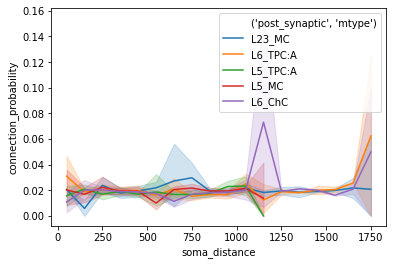

In [93]:
import seaborn; seaborn.set
axes = seaborn.lineplot(
    y="connection_probability",
    x="soma_distance",
    hue=("post_synaptic", "mtype"),
    data=cpm.reset_index())

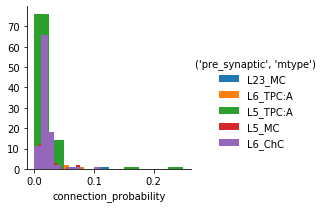

In [94]:
import matplotlib.pyplot as plt
graphic =\
    seaborn.FacetGrid(
        cpm.reset_index(),
        col=None,#"post_synaptic_mtype",
        hue=("pre_synaptic", "mtype"))
graphic.map(plt.hist, "connection_probability")
graphic.add_legend()

In [101]:
graphic =\
    seaborn.FacetGrid(
        cpm.reset_index(),
        hue=("pre_synaptic", "mtype"),
        #col=("post_synaptic", "mtype"),
        col_wrap=3, height=3.0)
graphic.map(
    seaborn.lineplot,
    "soma_distance",
    "connection_probability")
graphic.add_legend()

ValueError: num must be 1 <= num <= 0, not 1

<Figure size 648x0 with 0 Axes>

In [ ]:
graphic =\
    seaborn.FacetGrid(
        plotting_data,
        col="post_synaptic_mtype",
        hue="pre_synaptic_mtype")
        #legend_out=True)
graphic.map(
    seaborn.lineplot, 
    "soma_distance",
    "connection_probability",
    alpha=0.7)
graphic.add_legend()

In [ ]:
from dmt.tk.plotting.lines import LinePlot
line_plot = LinePlot(
    xvar="soma_distance",
    xlabel="Soma Distance",
    yvar="connection_probability",
    ylabel="Connection Probability",
    gvar="pre_synaptic_mtype",
    fvar="post_synaptic_mtype")

In [ ]:
line_plot.get_figure({
    "0": measured_values.reset_index().assign(
        soma_distance=lambda df: df.soma_distance.apply(np.mean)
    ).set_index(
        ["pre_synaptic_mtype", "post_synaptic_mtype", "soma_distance"])})

In [ ]:
result = conn_prob_sd(
    pathway=CellType.pathway(
        {"mtype": "L23_MC"},
        {"mtype": "L23_MC"}))
result

In [ ]:
result.reset_index(
).assign(
    soma_distance=lambda df: df.soma_distance.apply(np.mean)
).set_index(
    "soma_distance"
).connection_probability

In [30]:
pd.Series({
    "x": 1,
    "y": 2}
).set_value(
    "z", 10)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


x     1
y     2
z    10
dtype: int64